# Model phát hiện bất thường trong log OpenStack (nova) bằng LSTM + AutoEncoder

## Giới thiệu

Nova là dịch vụ quản lý compute của OpenStack, chịu trách nhiệm tạo, chạy và quản lý vòng đời VM. Khi Nova gặp lỗi bất thường—như scheduler sai, hypervisor quá tải, lỗi RPC, hoặc thất bại khi tạo VM chúng có thể gây ảnh hưởng trực tiếp đến hoạt động của toàn hệ thống. Việc phát hiện bất thường sớm trong log Nova giúp ngăn VM bị tạo lỗi, tránh downtime, phát hiện sự cố hạ tầng và hỗ trợ vận hành kịp thời

### Lý do chọn LSTM + AutoEncoder trong bài toán anomaly detection:

- Log của OpenStack nova có 3 level chính: INFO, WARNING và ERROR.
- Em đang xây dựng model để detect ra các bất thường trong tập dữ liệu chứa toàn log dạng INFO.
- Log Nova dù toàn INFO nhưng vẫn có thể chứa bất thường trong chuỗi sự kiện, nên không thể phát hiện nếu chỉ nhìn từng dòng.
- LSTM hiểu tốt dữ liệu dạng trình tự, nên bắt được pattern hoạt động bình thường của Nova.
- Khi kết hợp với Autoencoder, mô hình có thể học hành vi bình thường mà không cần label, phù hợp vì dữ liệu không có ERROR để train.
- Autoencoder tái tạo lại chuỗi bình thường tốt, nhưng tái tạo chuỗi bất thường kém → tạo ra reconstruction error để phát hiện anomaly.
- LSTM Encoder tạo ra biểu diễn nén của chuỗi log, giúp phân biệt những chuỗi INFO bình thường và những chuỗi INFO lệch pattern.
- Cách tiếp cận này tự động hơn rule-based và chịu được noise trong log như UUID, request-id, timestamp.

### Pipeline hệ thống

- Đầu vào: Log raw của OpenStack nova

- Pipeline xử lý:

    - Parse và chuẩn hóa log.

    - Tokenize chuỗi log và chuyển sang dạng số (embedding).

    - Đưa chuỗi vào mô hình LSTM Autoencoder.

    - Mô hình tái tạo lại chuỗi và tính reconstruction error.

    - So sánh error với ngưỡng để xác định log bình thường hay bất thường.

- Kết quả cuối cùng:

    - Gắn nhãn anomaly cho log.

## Import thư viện

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

## Load data đã qua xử lý

Phần xử lý data em để ở notebook [Openstack-log-parsing](https://www.kaggle.com/code/nguyensytan/openstack-log-parsing)

In [2]:
df = pd.read_csv("/kaggle/input/openstack-logs/train_log_processed.csv")

In [3]:
df

,Datetime,Pid,Level,Component,RequestID,Message,EventTemplate,EventID,ParameterList
0,2017-05-16 00:00:00.008,25746,INFO,nova.osapi_compute.wsgi.server,req-38101a0b-2096-447d-96ea-a692162415ae 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.1', '/v2/54fadb412c4e40cdbaed9335e4..."
1,2017-05-16 00:00:00.272,25746,INFO,nova.osapi_compute.wsgi.server,req-9bc36dd9-91c5-4314-898a-47625eb93b09 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.1', '/v2/54fadb412c4e40cdbaed9335e4..."
2,2017-05-16 00:00:01.551,25746,INFO,nova.osapi_compute.wsgi.server,req-55db2d8d-cdb7-4b4b-993b-429be84c0c3e 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.1', '/v2/54fadb412c4e40cdbaed9335e4..."
3,2017-05-16 00:00:01.813,25746,INFO,nova.osapi_compute.wsgi.server,req-2a3dc421-6604-42a7-9390-a18dc824d5d6 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.1', '/v2/54fadb412c4e40cdbaed9335e4..."
4,2017-05-16 00:00:03.091,25746,INFO,nova.osapi_compute.wsgi.server,req-939eb332-c1c1-4e67-99b8-8695f8f1980a 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.1', '/v2/54fadb412c4e40cdbaed9335e4..."
...,...,...,...,...,...,...,...,...,...
115403,2017-05-17 11:55:01.004,25751,INFO,nova.osapi_compute.wsgi.server,req-bf61e32a-7827-442f-85e3-708bfb56fc7d d16a6...,"10.11.10.1 ""GET /v2/e9746973ac574c6b8a9e8857f5...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.1', '/v2/e9746973ac574c6b8a9e8857f5..."
115404,2017-05-17 11:55:11.889,25740,INFO,nova.osapi_compute.wsgi.server,req-845e40e8-01fc-4d12-af3a-194090625e4b d16a6...,"10.11.10.2 ""GET /v2/e9746973ac574c6b8a9e8857f5...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.2', '/v2/e9746973ac574c6b8a9e8857f5..."
115405,2017-05-17 11:56:29.126,25998,INFO,nova.scheduler.host_manager,req-babdd83a-1e0e-40fa-bade-171fdf8fb4b4 - - -...,Successfully synced instances from host 'cp-1....,Successfully synced instances from host 'cp-1....,39,[]
115406,2017-05-17 11:58:30.368,25998,INFO,nova.scheduler.host_manager,req-61aea963-a8ea-406a-a397-283e156596ce - - -...,Successfully synced instances from host 'cp-1....,Successfully synced instances from host 'cp-1....,39,[]


## Xây dựng sequence

Các sự kiện trong log OpenStack có 1 trường là RequestID -> đưa những log cùng RequestID vào một chuỗi 

In [4]:
df = df.sort_values(by="Datetime")

sequences = (
    df.groupby("RequestID")["EventID"]
    .apply(list)
    .tolist()
)

sequences = [seq for seq in sequences if len(seq) >= 2]
print(sequences[-20:])

[[9, 10], [10, 29, 30, 33, 32, 31, 35, 34, 36, 37, 13, 14], [19, 20, 22, 23, 13, 24], [19, 20, 22, 23, 13, 24], [10, 29, 30, 31, 33, 32, 35, 34, 36, 37, 13, 14], [9, 10], [9, 10], [10, 29, 30, 31, 32, 33, 35, 34, 36, 37, 13, 14], [28, 10], [9, 10], [28, 10], [19, 20, 22, 23, 13, 24], [28, 10], [19, 20, 22, 23, 13, 24], [10, 29, 31, 30, 32, 33, 35, 34, 36, 37, 13, 14], [9, 10], [28, 10], [9, 10], [9, 10], [28, 10]]


Các sequence có chiều dài khác nhau mà LSTM là một neural networks cần input cố định -> pad để chúng có cùng size

In [5]:
def pad_sequence(seq, max_len, pad_value=0):
    padded = seq + [pad_value] * (max_len - len(seq))
    return padded

max_len = max(len(seq) for seq in sequences)

padded_sequences = [pad_sequence(seq, max_len) for seq in sequences]

padded_sequences = np.array(padded_sequences, dtype=np.int64)
padded_sequences.shape

(7477, 12)

## Chuẩn bị Pytorch dataset

In [6]:
class LogSequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        x = self.sequences[idx]
        return x, x

dataset = LogSequenceDataset(padded_sequences)

In [7]:
vocab_size = int(padded_sequences.max()) + 1

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"Vocabulary size: {vocab_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print()

Vocabulary size: 49
Training samples: 5981
Validation samples: 1496



## Xây dựng model LSTM Autoencoder

Ở đây em xây dựng 1 model LSTM Autoencoder có kiến trúc như sau:
```
Input Sequence (Token IDs)
        ↓
   [Embedding Layer]
        ↓
   [LSTM Encoder] ──→ Hidden State (Compressed)
        ↓
   [LSTM Decoder] ──→ Reconstruction
        ↓
   [Output Layer]
        ↓
Reconstructed Sequence (Logits)
```

Các tham số của model:
- vocab_size: số lượng token
- embed_dim: chiều của embedding vector
- hidden_dim: chiều của LSTM hidden state
- num_layers: số layer LSTM
- dropout: dropout rate

In [8]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=8, hidden_dim=16, num_layers=1, dropout=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        self.encoder = nn.LSTM(
            embed_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=0
        )
        
        self.decoder = nn.LSTM(
            embed_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=0
        )
        
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, sequence):
        batch_size, seq_length = sequence.size()
        
        embedded = self.embedding(sequence)
        _, (hidden, cell) = self.encoder(embedded)
        
        predictions = []
        decoder_input = sequence[:, 0]
        decoder_state = (hidden, cell)
        
        for t in range(seq_length):
            emb = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(emb, decoder_state)
            decoder_output = self.dropout(decoder_output.squeeze(1))
            logits = self.output_layer(decoder_output)
            predictions.append(logits)
            
            if t + 1 < seq_length:
                decoder_input = sequence[:, t + 1]
        
        output = torch.stack(predictions, dim=1)
        return output

## Huấn luyện model

### Khởi tạo, chọn tham số model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = LSTMAutoencoder(
    vocab_size=vocab_size,
    embed_dim=8,
    hidden_dim=16,
    num_layers=1,
    dropout=0.3
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
print()

Using device: cuda
Total parameters: 4,553



### Chọn tham số huấn luyện

In [10]:
learning_rate = 0.0001
num_epochs = 100
patience = 8
min_delta = 0.001

best_val_loss = float('inf')
patience_counter = 0
best_epoch = 0

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=1e-3
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5,
    patience=3,
    verbose=True,
    min_lr=1e-6
)

train_losses = []
val_losses = []
overfitting_gaps = []

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Huấn luyện

In [11]:
print("STARTING TRAINING")
print()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_batches = 0
    
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [TRAIN]')
    for batch_x, batch_y in train_bar:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_x)
        
        output_flat = output.view(-1, vocab_size)
        target_flat = batch_y.view(-1)
        
        loss = criterion(output_flat, target_flat)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
        train_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_loss = 0
    val_batches = 0
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [VAL]')
        for batch_x, batch_y in val_bar:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            output = model(batch_x)
            
            output_flat = output.view(-1, vocab_size)
            target_flat = batch_y.view(-1)
            
            loss = criterion(output_flat, target_flat)
            
            val_loss += loss.item()
            val_batches += 1
            val_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    gap = avg_train_loss - avg_val_loss
    overfitting_gaps.append(gap)
    
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Val Loss:   {avg_val_loss:.4f}')
    print(f'  Gap:        {gap:.4f}')
    print(f'  LR:         {current_lr:.6f}')
    
    # Early stopping
    improvement = best_val_loss - avg_val_loss
    
    if improvement > min_delta:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, 'lstm_autoencoder_model.pth')
        print(f'Model saved (improvement: {improvement:.4f})')
    else:
        patience_counter += 1
        print(f'  Patience: {patience_counter}/{patience} (improvement: {improvement:.4f})')
        
        if patience_counter >= patience:
            print(f'\n Early stopping at epoch {epoch+1}')
            print(f'   Best model was at epoch {best_epoch}')
            break
    
    print()

print("TRAINING COMPLETED!")
print(f"Best model from epoch: {best_epoch}")
print(f"Best validation loss: {best_val_loss:.4f}")
print()

STARTING TRAINING



Epoch 1/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 200.70it/s, loss=3.8750]



Epoch 1/100
  Train Loss: 3.8736
  Val Loss:   3.8491
  Gap:        0.0245
  LR:         0.000100
Model saved (improvement: inf)



Epoch 2/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 198.49it/s, loss=3.8186]



Epoch 2/100
  Train Loss: 3.8213
  Val Loss:   3.7922
  Gap:        0.0291
  LR:         0.000100
Model saved (improvement: 0.0569)



Epoch 3/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 198.50it/s, loss=3.7419]



Epoch 3/100
  Train Loss: 3.7556
  Val Loss:   3.7134
  Gap:        0.0422
  LR:         0.000100
Model saved (improvement: 0.0788)



Epoch 4/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 207.66it/s, loss=3.6054]



Epoch 4/100
  Train Loss: 3.6526
  Val Loss:   3.5767
  Gap:        0.0759
  LR:         0.000100
Model saved (improvement: 0.1367)



Epoch 5/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 199.38it/s, loss=3.3290]



Epoch 5/100
  Train Loss: 3.4661
  Val Loss:   3.3249
  Gap:        0.1412
  LR:         0.000100
Model saved (improvement: 0.2518)



Epoch 6/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 201.28it/s, loss=3.0284]



Epoch 6/100
  Train Loss: 3.2101
  Val Loss:   3.0620
  Gap:        0.1481
  LR:         0.000100
Model saved (improvement: 0.2629)



Epoch 7/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 197.27it/s, loss=2.7841]



Epoch 7/100
  Train Loss: 2.9808
  Val Loss:   2.8465
  Gap:        0.1343
  LR:         0.000100
Model saved (improvement: 0.2155)



Epoch 8/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 207.07it/s, loss=2.5783]



Epoch 8/100
  Train Loss: 2.7935
  Val Loss:   2.6654
  Gap:        0.1281
  LR:         0.000100
Model saved (improvement: 0.1811)



Epoch 9/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 206.41it/s, loss=2.4021]



Epoch 9/100
  Train Loss: 2.6331
  Val Loss:   2.5085
  Gap:        0.1246
  LR:         0.000100
Model saved (improvement: 0.1569)



Epoch 10/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 203.43it/s, loss=2.2555]



Epoch 10/100
  Train Loss: 2.4956
  Val Loss:   2.3728
  Gap:        0.1228
  LR:         0.000100
Model saved (improvement: 0.1357)



Epoch 11/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 204.71it/s, loss=2.1303]



Epoch 11/100
  Train Loss: 2.3771
  Val Loss:   2.2544
  Gap:        0.1226
  LR:         0.000100
Model saved (improvement: 0.1183)



Epoch 12/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 198.20it/s, loss=2.0208]



Epoch 12/100
  Train Loss: 2.2702
  Val Loss:   2.1490
  Gap:        0.1212
  LR:         0.000100
Model saved (improvement: 0.1054)



Epoch 13/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 199.33it/s, loss=1.9226]



Epoch 13/100
  Train Loss: 2.1711
  Val Loss:   2.0526
  Gap:        0.1185
  LR:         0.000100
Model saved (improvement: 0.0964)



Epoch 14/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 194.78it/s, loss=1.8329]



Epoch 14/100
  Train Loss: 2.0858
  Val Loss:   1.9635
  Gap:        0.1222
  LR:         0.000100
Model saved (improvement: 0.0891)



Epoch 15/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 201.29it/s, loss=1.7495]



Epoch 15/100
  Train Loss: 2.0086
  Val Loss:   1.8803
  Gap:        0.1283
  LR:         0.000100
Model saved (improvement: 0.0832)



Epoch 16/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 199.54it/s, loss=1.6711]



Epoch 16/100
  Train Loss: 1.9291
  Val Loss:   1.8015
  Gap:        0.1276
  LR:         0.000100
Model saved (improvement: 0.0788)



Epoch 17/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 203.15it/s, loss=1.5977]



Epoch 17/100
  Train Loss: 1.8557
  Val Loss:   1.7268
  Gap:        0.1289
  LR:         0.000100
Model saved (improvement: 0.0747)



Epoch 18/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 200.77it/s, loss=1.5274]



Epoch 18/100
  Train Loss: 1.7845
  Val Loss:   1.6557
  Gap:        0.1288
  LR:         0.000100
Model saved (improvement: 0.0711)



Epoch 19/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 201.00it/s, loss=1.4614]



Epoch 19/100
  Train Loss: 1.7210
  Val Loss:   1.5882
  Gap:        0.1327
  LR:         0.000100
Model saved (improvement: 0.0674)



Epoch 20/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 207.36it/s, loss=1.3991]



Epoch 20/100
  Train Loss: 1.6582
  Val Loss:   1.5244
  Gap:        0.1338
  LR:         0.000100
Model saved (improvement: 0.0638)



Epoch 21/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 202.39it/s, loss=1.3397]



Epoch 21/100
  Train Loss: 1.6026
  Val Loss:   1.4646
  Gap:        0.1380
  LR:         0.000100
Model saved (improvement: 0.0599)



Epoch 22/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 201.90it/s, loss=1.2842]



Epoch 22/100
  Train Loss: 1.5464
  Val Loss:   1.4082
  Gap:        0.1382
  LR:         0.000100
Model saved (improvement: 0.0564)



Epoch 23/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 203.10it/s, loss=1.2324]



Epoch 23/100
  Train Loss: 1.4948
  Val Loss:   1.3549
  Gap:        0.1399
  LR:         0.000100
Model saved (improvement: 0.0533)



Epoch 24/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 203.49it/s, loss=1.1838]



Epoch 24/100
  Train Loss: 1.4458
  Val Loss:   1.3046
  Gap:        0.1413
  LR:         0.000100
Model saved (improvement: 0.0503)



Epoch 25/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 204.34it/s, loss=1.1374]



Epoch 25/100
  Train Loss: 1.4012
  Val Loss:   1.2567
  Gap:        0.1445
  LR:         0.000100
Model saved (improvement: 0.0479)



Epoch 26/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 204.99it/s, loss=1.0938]



Epoch 26/100
  Train Loss: 1.3554
  Val Loss:   1.2113
  Gap:        0.1441
  LR:         0.000100
Model saved (improvement: 0.0454)



Epoch 27/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 205.95it/s, loss=1.0522]



Epoch 27/100
  Train Loss: 1.3110
  Val Loss:   1.1675
  Gap:        0.1435
  LR:         0.000100
Model saved (improvement: 0.0438)



Epoch 28/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 207.23it/s, loss=1.0122]



Epoch 28/100
  Train Loss: 1.2688
  Val Loss:   1.1255
  Gap:        0.1434
  LR:         0.000100
Model saved (improvement: 0.0420)



Epoch 29/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 197.23it/s, loss=0.9730]



Epoch 29/100
  Train Loss: 1.2336
  Val Loss:   1.0847
  Gap:        0.1489
  LR:         0.000100
Model saved (improvement: 0.0407)



Epoch 30/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 205.01it/s, loss=0.9356]



Epoch 30/100
  Train Loss: 1.1938
  Val Loss:   1.0451
  Gap:        0.1487
  LR:         0.000100
Model saved (improvement: 0.0396)



Epoch 31/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 202.44it/s, loss=0.8988]



Epoch 31/100
  Train Loss: 1.1555
  Val Loss:   1.0061
  Gap:        0.1494
  LR:         0.000100
Model saved (improvement: 0.0390)



Epoch 32/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 208.78it/s, loss=0.8630]



Epoch 32/100
  Train Loss: 1.1199
  Val Loss:   0.9684
  Gap:        0.1515
  LR:         0.000100
Model saved (improvement: 0.0377)



Epoch 33/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 197.36it/s, loss=0.8278]



Epoch 33/100
  Train Loss: 1.0867
  Val Loss:   0.9317
  Gap:        0.1550
  LR:         0.000100
Model saved (improvement: 0.0368)



Epoch 34/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 205.58it/s, loss=0.7941]



Epoch 34/100
  Train Loss: 1.0511
  Val Loss:   0.8960
  Gap:        0.1551
  LR:         0.000100
Model saved (improvement: 0.0357)



Epoch 35/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 200.07it/s, loss=0.7614]



Epoch 35/100
  Train Loss: 1.0198
  Val Loss:   0.8613
  Gap:        0.1585
  LR:         0.000100
Model saved (improvement: 0.0347)



Epoch 36/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 194.56it/s, loss=0.7293]



Epoch 36/100
  Train Loss: 0.9855
  Val Loss:   0.8272
  Gap:        0.1583
  LR:         0.000100
Model saved (improvement: 0.0341)



Epoch 37/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 205.17it/s, loss=0.6982]



Epoch 37/100
  Train Loss: 0.9502
  Val Loss:   0.7941
  Gap:        0.1561
  LR:         0.000100
Model saved (improvement: 0.0331)



Epoch 38/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 204.05it/s, loss=0.6683]



Epoch 38/100
  Train Loss: 0.9201
  Val Loss:   0.7621
  Gap:        0.1580
  LR:         0.000100
Model saved (improvement: 0.0320)



Epoch 39/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 202.05it/s, loss=0.6394]



Epoch 39/100
  Train Loss: 0.8940
  Val Loss:   0.7311
  Gap:        0.1629
  LR:         0.000100
Model saved (improvement: 0.0309)



Epoch 40/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 206.44it/s, loss=0.6118]



Epoch 40/100
  Train Loss: 0.8620
  Val Loss:   0.7016
  Gap:        0.1604
  LR:         0.000100
Model saved (improvement: 0.0295)



Epoch 41/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 198.59it/s, loss=0.5860]



Epoch 41/100
  Train Loss: 0.8344
  Val Loss:   0.6731
  Gap:        0.1613
  LR:         0.000100
Model saved (improvement: 0.0285)



Epoch 42/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 198.53it/s, loss=0.5613]



Epoch 42/100
  Train Loss: 0.8101
  Val Loss:   0.6460
  Gap:        0.1641
  LR:         0.000100
Model saved (improvement: 0.0271)



Epoch 43/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 198.07it/s, loss=0.5379]



Epoch 43/100
  Train Loss: 0.7822
  Val Loss:   0.6200
  Gap:        0.1622
  LR:         0.000100
Model saved (improvement: 0.0260)



Epoch 44/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 194.59it/s, loss=0.5153]



Epoch 44/100
  Train Loss: 0.7617
  Val Loss:   0.5951
  Gap:        0.1667
  LR:         0.000100
Model saved (improvement: 0.0249)



Epoch 45/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 204.35it/s, loss=0.4939]



Epoch 45/100
  Train Loss: 0.7351
  Val Loss:   0.5711
  Gap:        0.1640
  LR:         0.000100
Model saved (improvement: 0.0240)



Epoch 46/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 204.63it/s, loss=0.4735]



Epoch 46/100
  Train Loss: 0.7111
  Val Loss:   0.5482
  Gap:        0.1629
  LR:         0.000100
Model saved (improvement: 0.0229)



Epoch 47/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 198.43it/s, loss=0.4540]



Epoch 47/100
  Train Loss: 0.6922
  Val Loss:   0.5262
  Gap:        0.1660
  LR:         0.000100
Model saved (improvement: 0.0220)



Epoch 48/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 201.25it/s, loss=0.4356]



Epoch 48/100
  Train Loss: 0.6701
  Val Loss:   0.5051
  Gap:        0.1649
  LR:         0.000100
Model saved (improvement: 0.0211)



Epoch 49/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 196.89it/s, loss=0.4175]



Epoch 49/100
  Train Loss: 0.6503
  Val Loss:   0.4849
  Gap:        0.1654
  LR:         0.000100
Model saved (improvement: 0.0202)



Epoch 50/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 200.74it/s, loss=0.4003]



Epoch 50/100
  Train Loss: 0.6270
  Val Loss:   0.4654
  Gap:        0.1616
  LR:         0.000100
Model saved (improvement: 0.0195)



Epoch 51/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 201.28it/s, loss=0.3843]



Epoch 51/100
  Train Loss: 0.6101
  Val Loss:   0.4470
  Gap:        0.1631
  LR:         0.000100
Model saved (improvement: 0.0184)



Epoch 52/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 193.15it/s, loss=0.3688]



Epoch 52/100
  Train Loss: 0.5916
  Val Loss:   0.4292
  Gap:        0.1624
  LR:         0.000100
Model saved (improvement: 0.0179)



Epoch 53/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 203.37it/s, loss=0.3542]



Epoch 53/100
  Train Loss: 0.5766
  Val Loss:   0.4124
  Gap:        0.1642
  LR:         0.000100
Model saved (improvement: 0.0167)



Epoch 54/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 200.40it/s, loss=0.3397]



Epoch 54/100
  Train Loss: 0.5606
  Val Loss:   0.3960
  Gap:        0.1647
  LR:         0.000100
Model saved (improvement: 0.0165)



Epoch 55/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 200.95it/s, loss=0.3260]



Epoch 55/100
  Train Loss: 0.5412
  Val Loss:   0.3803
  Gap:        0.1609
  LR:         0.000100
Model saved (improvement: 0.0157)



Epoch 56/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 184.25it/s, loss=0.3134]



Epoch 56/100
  Train Loss: 0.5268
  Val Loss:   0.3656
  Gap:        0.1612
  LR:         0.000100
Model saved (improvement: 0.0147)



Epoch 57/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 197.16it/s, loss=0.3010]



Epoch 57/100
  Train Loss: 0.5091
  Val Loss:   0.3513
  Gap:        0.1578
  LR:         0.000100
Model saved (improvement: 0.0143)



Epoch 58/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 208.69it/s, loss=0.2891]



Epoch 58/100
  Train Loss: 0.4986
  Val Loss:   0.3374
  Gap:        0.1612
  LR:         0.000100
Model saved (improvement: 0.0139)



Epoch 59/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 203.05it/s, loss=0.2776]



Epoch 59/100
  Train Loss: 0.4854
  Val Loss:   0.3242
  Gap:        0.1612
  LR:         0.000100
Model saved (improvement: 0.0132)



Epoch 60/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 192.64it/s, loss=0.2671]



Epoch 60/100
  Train Loss: 0.4689
  Val Loss:   0.3116
  Gap:        0.1573
  LR:         0.000100
Model saved (improvement: 0.0125)



Epoch 61/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 204.72it/s, loss=0.2572]



Epoch 61/100
  Train Loss: 0.4571
  Val Loss:   0.2998
  Gap:        0.1573
  LR:         0.000100
Model saved (improvement: 0.0119)



Epoch 62/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 205.11it/s, loss=0.2471]



Epoch 62/100
  Train Loss: 0.4452
  Val Loss:   0.2879
  Gap:        0.1573
  LR:         0.000100
Model saved (improvement: 0.0118)



Epoch 63/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 210.93it/s, loss=0.2378]



Epoch 63/100
  Train Loss: 0.4338
  Val Loss:   0.2768
  Gap:        0.1570
  LR:         0.000100
Model saved (improvement: 0.0112)



Epoch 64/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 210.43it/s, loss=0.2291]



Epoch 64/100
  Train Loss: 0.4242
  Val Loss:   0.2662
  Gap:        0.1580
  LR:         0.000100
Model saved (improvement: 0.0105)



Epoch 65/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 200.01it/s, loss=0.2199]



Epoch 65/100
  Train Loss: 0.4099
  Val Loss:   0.2557
  Gap:        0.1543
  LR:         0.000100
Model saved (improvement: 0.0106)



Epoch 66/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 202.16it/s, loss=0.2117]



Epoch 66/100
  Train Loss: 0.4019
  Val Loss:   0.2458
  Gap:        0.1560
  LR:         0.000100
Model saved (improvement: 0.0098)



Epoch 67/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 196.85it/s, loss=0.2035]



Epoch 67/100
  Train Loss: 0.3921
  Val Loss:   0.2364
  Gap:        0.1557
  LR:         0.000100
Model saved (improvement: 0.0094)



Epoch 68/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 200.06it/s, loss=0.1958]



Epoch 68/100
  Train Loss: 0.3776
  Val Loss:   0.2273
  Gap:        0.1503
  LR:         0.000100
Model saved (improvement: 0.0091)



Epoch 69/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 199.07it/s, loss=0.1888]



Epoch 69/100
  Train Loss: 0.3679
  Val Loss:   0.2186
  Gap:        0.1493
  LR:         0.000100
Model saved (improvement: 0.0086)



Epoch 70/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 200.51it/s, loss=0.1820]



Epoch 70/100
  Train Loss: 0.3552
  Val Loss:   0.2103
  Gap:        0.1448
  LR:         0.000100
Model saved (improvement: 0.0083)



Epoch 71/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 197.85it/s, loss=0.1753]



Epoch 71/100
  Train Loss: 0.3489
  Val Loss:   0.2024
  Gap:        0.1466
  LR:         0.000100
Model saved (improvement: 0.0080)



Epoch 72/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 202.71it/s, loss=0.1688]



Epoch 72/100
  Train Loss: 0.3392
  Val Loss:   0.1946
  Gap:        0.1446
  LR:         0.000100
Model saved (improvement: 0.0077)



Epoch 73/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 209.88it/s, loss=0.1625]



Epoch 73/100
  Train Loss: 0.3315
  Val Loss:   0.1873
  Gap:        0.1442
  LR:         0.000100
Model saved (improvement: 0.0074)



Epoch 74/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 194.53it/s, loss=0.1566]



Epoch 74/100
  Train Loss: 0.3259
  Val Loss:   0.1803
  Gap:        0.1456
  LR:         0.000100
Model saved (improvement: 0.0070)



Epoch 75/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 197.60it/s, loss=0.1509]



Epoch 75/100
  Train Loss: 0.3181
  Val Loss:   0.1737
  Gap:        0.1444
  LR:         0.000100
Model saved (improvement: 0.0066)



Epoch 76/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 208.86it/s, loss=0.1456]



Epoch 76/100
  Train Loss: 0.3077
  Val Loss:   0.1673
  Gap:        0.1404
  LR:         0.000100
Model saved (improvement: 0.0064)



Epoch 77/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 199.39it/s, loss=0.1405]



Epoch 77/100
  Train Loss: 0.3024
  Val Loss:   0.1613
  Gap:        0.1411
  LR:         0.000100
Model saved (improvement: 0.0060)



Epoch 78/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 201.10it/s, loss=0.1355]



Epoch 78/100
  Train Loss: 0.2915
  Val Loss:   0.1555
  Gap:        0.1360
  LR:         0.000100
Model saved (improvement: 0.0058)



Epoch 79/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 205.68it/s, loss=0.1307]



Epoch 79/100
  Train Loss: 0.2874
  Val Loss:   0.1499
  Gap:        0.1375
  LR:         0.000100
Model saved (improvement: 0.0056)



Epoch 80/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 204.62it/s, loss=0.1263]



Epoch 80/100
  Train Loss: 0.2817
  Val Loss:   0.1447
  Gap:        0.1371
  LR:         0.000100
Model saved (improvement: 0.0053)



Epoch 81/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 205.00it/s, loss=0.1219]



Epoch 81/100
  Train Loss: 0.2766
  Val Loss:   0.1396
  Gap:        0.1370
  LR:         0.000100
Model saved (improvement: 0.0051)



Epoch 82/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 205.64it/s, loss=0.1177]



Epoch 82/100
  Train Loss: 0.2699
  Val Loss:   0.1346
  Gap:        0.1353
  LR:         0.000100
Model saved (improvement: 0.0050)



Epoch 83/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 202.80it/s, loss=0.1136]



Epoch 83/100
  Train Loss: 0.2611
  Val Loss:   0.1299
  Gap:        0.1313
  LR:         0.000100
Model saved (improvement: 0.0047)



Epoch 84/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 210.60it/s, loss=0.1097]



Epoch 84/100
  Train Loss: 0.2572
  Val Loss:   0.1253
  Gap:        0.1319
  LR:         0.000100
Model saved (improvement: 0.0045)



Epoch 85/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 195.27it/s, loss=0.1059]



Epoch 85/100
  Train Loss: 0.2493
  Val Loss:   0.1209
  Gap:        0.1284
  LR:         0.000100
Model saved (improvement: 0.0044)



Epoch 86/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 205.04it/s, loss=0.1023]



Epoch 86/100
  Train Loss: 0.2448
  Val Loss:   0.1167
  Gap:        0.1282
  LR:         0.000100
Model saved (improvement: 0.0042)



Epoch 87/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 196.08it/s, loss=0.0988]



Epoch 87/100
  Train Loss: 0.2384
  Val Loss:   0.1126
  Gap:        0.1258
  LR:         0.000100
Model saved (improvement: 0.0041)



Epoch 88/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 200.06it/s, loss=0.0954]



Epoch 88/100
  Train Loss: 0.2313
  Val Loss:   0.1086
  Gap:        0.1227
  LR:         0.000100
Model saved (improvement: 0.0039)



Epoch 89/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 208.38it/s, loss=0.0920]



Epoch 89/100
  Train Loss: 0.2285
  Val Loss:   0.1048
  Gap:        0.1237
  LR:         0.000100
Model saved (improvement: 0.0038)



Epoch 90/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 202.55it/s, loss=0.0888]



Epoch 90/100
  Train Loss: 0.2230
  Val Loss:   0.1012
  Gap:        0.1218
  LR:         0.000100
Model saved (improvement: 0.0037)



Epoch 91/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 204.82it/s, loss=0.0856]



Epoch 91/100
  Train Loss: 0.2185
  Val Loss:   0.0976
  Gap:        0.1209
  LR:         0.000100
Model saved (improvement: 0.0035)



Epoch 92/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 192.01it/s, loss=0.0826]



Epoch 92/100
  Train Loss: 0.2097
  Val Loss:   0.0943
  Gap:        0.1154
  LR:         0.000100
Model saved (improvement: 0.0034)



Epoch 93/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 204.35it/s, loss=0.0797]



Epoch 93/100
  Train Loss: 0.2090
  Val Loss:   0.0909
  Gap:        0.1180
  LR:         0.000100
Model saved (improvement: 0.0033)



Epoch 94/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 202.64it/s, loss=0.0769]



Epoch 94/100
  Train Loss: 0.2024
  Val Loss:   0.0878
  Gap:        0.1146
  LR:         0.000100
Model saved (improvement: 0.0032)



Epoch 95/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 203.31it/s, loss=0.0742]



Epoch 95/100
  Train Loss: 0.2003
  Val Loss:   0.0847
  Gap:        0.1156
  LR:         0.000100
Model saved (improvement: 0.0031)



Epoch 96/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 197.75it/s, loss=0.0714]



Epoch 96/100
  Train Loss: 0.1959
  Val Loss:   0.0817
  Gap:        0.1142
  LR:         0.000100
Model saved (improvement: 0.0030)



Epoch 97/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 208.61it/s, loss=0.0689]



Epoch 97/100
  Train Loss: 0.1930
  Val Loss:   0.0788
  Gap:        0.1142
  LR:         0.000100
Model saved (improvement: 0.0029)



Epoch 98/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 206.18it/s, loss=0.0663]



Epoch 98/100
  Train Loss: 0.1856
  Val Loss:   0.0760
  Gap:        0.1096
  LR:         0.000100
Model saved (improvement: 0.0028)



Epoch 99/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 204.18it/s, loss=0.0638]



Epoch 99/100
  Train Loss: 0.1824
  Val Loss:   0.0732
  Gap:        0.1091
  LR:         0.000100
Model saved (improvement: 0.0028)



Epoch 100/100 [VAL]: 100%|██████████| 24/24 [00:00<00:00, 203.57it/s, loss=0.0615]



Epoch 100/100
  Train Loss: 0.1776
  Val Loss:   0.0706
  Gap:        0.1071
  LR:         0.000100
Model saved (improvement: 0.0027)

TRAINING COMPLETED!
Best model from epoch: 100
Best validation loss: 0.0706



### Visualize kết quả

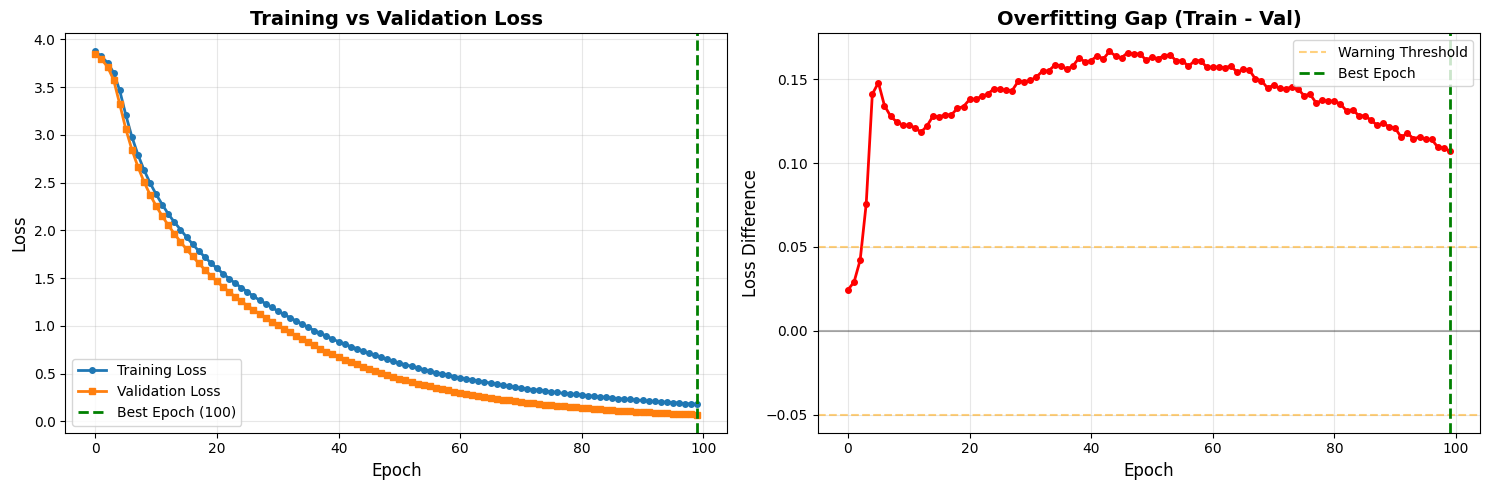

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o', linewidth=2, markersize=4)
plt.plot(val_losses, label='Validation Loss', marker='s', linewidth=2, markersize=4)
plt.axvline(x=best_epoch-1, color='green', linestyle='--', linewidth=2, label=f'Best Epoch ({best_epoch})')
plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(overfitting_gaps, marker='o', linewidth=2, markersize=4, color='red')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='Warning Threshold')
plt.axhline(y=-0.05, color='orange', linestyle='--', alpha=0.5)
plt.axvline(x=best_epoch-1, color='green', linestyle='--', linewidth=2, label=f'Best Epoch')
plt.title('Overfitting Gap (Train - Val)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Difference', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Đánh giá reconstruction error

In [13]:
def calculate_reconstruction_error(model, sequences, device):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='none')
    
    errors = []
    
    with torch.no_grad():
        for seq in sequences:
            seq_tensor = torch.tensor(seq).unsqueeze(0).to(device)
            
            output = model(seq_tensor)
            
            output_flat = output.view(-1, model.vocab_size)
            target_flat = seq_tensor.view(-1)
            
            token_losses = criterion(output_flat, target_flat)
            
            mask = target_flat != 0
            if mask.sum() > 0:
                error = token_losses[mask].mean().item()
            else:
                error = 0.0
            
            errors.append(error)
    
    return np.array(errors)


In [14]:
model = LSTMAutoencoder(vocab_size=49, embed_dim=8, hidden_dim=16)
checkpoint = torch.load('lstm_autoencoder_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_sequences = []
for batch_x, _ in train_loader:
    train_sequences.extend(batch_x.numpy())

val_sequences = []
for batch_x, _ in val_loader:
    val_sequences.extend(batch_x.numpy())

train_errors = calculate_reconstruction_error(model, train_sequences, device)
val_errors = calculate_reconstruction_error(model, val_sequences, device)

In [15]:
# Xác định threshold dựa trên train errors
threshold = train_errors.mean() + 2 * train_errors.std()
print(f"\nThreshold (mean + 2*std): {threshold:.6f}")


Threshold (mean + 2*std): 0.304391


In [16]:
# Thử lấy một sequence bình thường xem model có phát hiện bất thường hay không
new_sequence = [[19, 20, 22, 23, 13, 24]]
error = calculate_reconstruction_error(model, new_sequence, device)
print(f"\nSequence error: {error[0]:.6f}")
if error[0] > threshold:
    print("ANOMALY DETECTED!")
else:
    print("Normal sequence")


Sequence error: 0.089325
Normal sequence


In [17]:
# Thử đưa 1 chuỗi bất kỳ có bất thường vào
another_sequence = [[1, 2, 3, 4 ,5, 6, 7, 8, 9]]
error = calculate_reconstruction_error(model, another_sequence, device)
print(f"\nSequence error: {error[0]:.6f}")
if error[0] > threshold:
    print("ANOMALY DETECTED!")
else:
    print("Normal sequence")


Sequence error: 7.503406
ANOMALY DETECTED!


# Test kết quả trên tập test

Tập test ở đây lấy một tập ngẫu nhiên có 12k dòng log, chưa biết trước log đó có bất thường hay là không, phần xử lý log test raw đã xử lý trước đó ở notebook https://www.kaggle.com/code/nguyensytan/openstack-log-parsing

In [18]:
test_df = pd.read_csv("/kaggle/input/openstack-logs/test_log_processed.csv")

In [19]:
test_df

,Datetime,Pid,Level,Component,RequestID,Message,EventTemplate,EventID,ParameterList
0,2017-05-14 19:39:01.445,25746,INFO,nova.osapi_compute.wsgi.server,req-5a2050e7-b381-4ae9-92d2-8b08e9f9f4c0 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.1', '/v2/54fadb412c4e40cdbaed9335e4..."
1,2017-05-14 19:39:01.650,25746,INFO,nova.osapi_compute.wsgi.server,req-c26a7d54-55ab-412e-947f-421a2cb934fc 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.1', '/v2/54fadb412c4e40cdbaed9335e4..."
2,2017-05-14 19:39:02.007,2931,INFO,nova.virt.libvirt.driver,req-e285b551-587f-4c1d-8eba-dceb2673637f 113d3...,[instance: 3edec1e4-9678-4a3a-a21b-a145a4ee5e6...,<*> Creating image,37,['[instance: 3edec1e4-9678-4a3a-a21b-a145a4ee5...
3,2017-05-14 19:39:02.924,25746,INFO,nova.osapi_compute.wsgi.server,req-eb681812-78ae-4a9f-9e2a-96e505285512 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.1', '/v2/54fadb412c4e40cdbaed9335e4..."
4,2017-05-14 19:39:03.201,25746,INFO,nova.osapi_compute.wsgi.server,req-050312b7-c94e-4773-9319-c330e1f3fdaa 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.1', '/v2/54fadb412c4e40cdbaed9335e4..."
...,...,...,...,...,...,...,...,...,...
12164,2017-05-14 21:56:04.720,25746,INFO,nova.osapi_compute.wsgi.server,req-24f300c0-78c1-4d11-a42a-dc50068d5391 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.1', '/v2/54fadb412c4e40cdbaed9335e4..."
12165,2017-05-14 21:56:06.113,25746,INFO,nova.osapi_compute.wsgi.server,req-eb71a4fc-c3e1-487c-86f7-ea9d5308be52 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.1', '/v2/54fadb412c4e40cdbaed9335e4..."
12166,2017-05-14 21:56:06.397,25746,INFO,nova.osapi_compute.wsgi.server,req-ca1c2b93-04bd-41b3-a4c5-89b03f430403 113d3...,"10.11.10.1 ""GET /v2/54fadb412c4e40cdbaed9335e4...","<*> ""GET <*> HTTP<*>"" status: <*> len: <*> tim...",2,"['10.11.10.1', '/v2/54fadb412c4e40cdbaed9335e4..."
12167,2017-05-14 21:56:20.003,2931,INFO,nova.compute.manager,req-5ea748e3-f320-422e-910f-c17e50d4007c 113d3...,[instance: 5b98ace2-4126-46c3-a43e-1e1d879f0a8...,<*> Took <*> seconds to <*> the instance on th...,13,['[instance: 5b98ace2-4126-46c3-a43e-1e1d879f0...


In [20]:
test_df = test_df.sort_values(by="Datetime")

test_sequences = (
    test_df.groupby("RequestID")["EventID"]
    .apply(list)
    .tolist()
)

test_sequences = [seq for seq in test_sequences if 2 <= len(seq) <= 12]

In [21]:
def pad_sequence(seq, max_len, pad_value=0):
    padded = seq + [pad_value] * (max_len - len(seq))
    return padded

max_len = max(len(seq) for seq in test_sequences)

test_padded_sequences = [pad_sequence(seq, max_len) for seq in test_sequences]

test_padded_sequences = np.array(test_padded_sequences, dtype=np.int64)
test_padded_sequences.shape

(785, 12)

In [22]:
test_dataset = LogSequenceDataset(test_padded_sequences)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

test_sequences = []
for batch_x, _ in test_loader:
    test_sequences.extend(batch_x.numpy())

In [23]:
test_errors = calculate_reconstruction_error(model, test_sequences, device)
threshold = np.percentile(train_errors, 99)

anomalies = test_errors > threshold
num_anomalies = anomalies.sum()

print(f"\nDetected anomalies: {num_anomalies}/{len(test_errors)}")
print(f"Anomaly rate: {100*num_anomalies/len(test_errors):.2f}%")


Detected anomalies: 5/785
Anomaly rate: 0.64%
